<a href="https://colab.research.google.com/github/RedDawe/reddit_comments_sentiment/blob/main/reddit_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install praw

In [61]:
import requests
import matplotlib.pyplot as plt
import time

In [118]:
# TAKEN FROM https://towardsdatascience.com/automate-sentiment-analysis-process-for-reddit-post-textblob-and-vader-8a79c269522f
# API DOCS https://github.com/pushshift/api

# PRAW to interact with reddit
import praw
#install textblob if not already installed using "pip install -U textblob"
from textblob import TextBlob
import nltk
# Download VADER, if not downloaded
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# create object for VADER sentiment function interaction
nltk.downloader.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

reddit = praw.Reddit(client_id='dwvhQN_PoUCoAw',
                     client_secret='X8N_SZUsiI-CNVIYLToBFFQ-cYE',
                     user_agent='news on hooks')

# get 10 hot posts from the showerthoughts subreddit
top_posts = reddit.subreddit('showerthoughts').top('week', limit=5)

# Sentiment analysis function for TextBlob tools
def text_blob_sentiment(review, sub_entries_textblob):
    analysis = TextBlob(review)
    if analysis.sentiment.polarity >= 0.0001:
        if analysis.sentiment.polarity > 0:
            sub_entries_textblob['positive'] = sub_entries_textblob['positive'] + 1
            return 'Positive'

    elif analysis.sentiment.polarity <= -0.0001:
        if analysis.sentiment.polarity <= 0:
            sub_entries_textblob['negative'] = sub_entries_textblob['negative'] + 1
            return 'Negative'
    else:
        sub_entries_textblob['neutral'] = sub_entries_textblob['neutral'] + 1
        return 'Neutral'
    

# sentiment analysis function for VADER tool
def nltk_sentiment(review, sub_entries_nltk):
    vs = sia.polarity_scores(review)
    if not vs['neg'] > 0.05:
        if vs['pos'] - vs['neg'] > 0:
            sub_entries_nltk['positive'] = sub_entries_nltk['positive'] + 1
            return 'Positive'
        else:
            sub_entries_nltk['neutral'] = sub_entries_nltk['neutral'] + 1
            return 'Neutral'

    elif not vs['pos'] > 0.05:
        if vs['pos'] - vs['neg'] <= 0:
            sub_entries_nltk['negative'] = sub_entries_nltk['negative'] + 1
            return 'Negative'
        else:
            sub_entries_nltk['neutral'] = sub_entries_nltk['neutral'] + 1
            return 'Neutral'
    else:
        sub_entries_nltk['neutral'] = sub_entries_nltk['neutral'] + 1
        return 'Neutral'


# replication of comment section of reddit post
def replies_of(top_level_comment, count_comment, sub_entries_textblob, sub_entries_nltk):
    if len(top_level_comment.replies) == 0:
        count_comment = 0
        return
    else:
        for num, comment in enumerate(top_level_comment.replies):
            try:
                count_comment += 1
                print('-' * count_comment, comment.body)
                text_blob_sentiment(comment.body, sub_entries_textblob)
                nltk_sentiment(comment.body, sub_entries_nltk)
            except:
                continue
            replies_of(comment, count_comment, sub_entries_textblob,sub_entries_nltk)


def main():
    
    for submission in top_posts:
        sub_entries_textblob = {'negative': 0, 'positive' : 0, 'neutral' : 0}
        sub_entries_nltk = {'negative': 0, 'positive' : 0, 'neutral' : 0}
        print('Title of the post :', submission.title)
        text_blob_sentiment(submission.title, sub_entries_textblob)
        nltk_sentiment(submission.title, sub_entries_nltk)
        print("\n")
        submission_comm = reddit.submission(id=submission.id)

        for count, top_level_comment in enumerate(submission_comm.comments):
            print(f"-------------{count} top level comment start--------------")
            count_comm = 0
            try :
                print(top_level_comment.body)
                text_blob_sentiment(top_level_comment.body, sub_entries_textblob)
                nltk_sentiment(top_level_comment.body, sub_entries_nltk)
                replies_of(top_level_comment,
                           count_comm,
                           sub_entries_textblob,
                           sub_entries_nltk)
            except:
                continue
        print('Over all Sentiment of Topic by TextBlob :', sub_entries_textblob)
        print('Over all Sentiment of Topic by VADER :', sub_entries_nltk)
        print("\n\n\n")

# main()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [119]:
def get_sentiment_in_year(term='trump', after=1500, before=1499):
  print('https://api.pushshift.io/reddit/search/comment/?q={term}&after={after}d&before={before}d&sort=desc&size=500&sort_type=score'.format(term=term, after=after, before=before))
  son = requests.get('https://api.pushshift.io/reddit/search/comment/?q={term}&after={after}d&before={before}d&sort=desc&size=500&sort_type=score'.format(term=term, after=after, before=before)).json()

  sub_entries_textblob = {'negative': 0, 'positive' : 0, 'neutral' : 0}
  sub_entries_nltk = {'negative': 0, 'positive' : 0, 'neutral' : 0}
  for com in son['data']:
    text_blob_sentiment(com['body'], sub_entries_textblob)
    nltk_sentiment(com['body'], sub_entries_nltk)

  return sub_entries_textblob, sub_entries_nltk

In [120]:
def visualize_dick(dct):
  y = []
  cnt = []
  for year in dct:
    y.append(year['positive']-year['negative'])
    cnt.append(year['positive']+year['negative']+year['neutral'])

  fig, (ax1, ax2) = plt.subplots(2)
  ax1.plot(y)
  ax2.plot(cnt)

In [121]:
def analisis(frames=5, step=365, size=365):
  dcts0 = []
  dcts1 = []
  for year in range(0, frames*step, step):
    dct0, dct1 = get_sentiment_in_year('tesla', year+size, year)
    dcts0.append(dct0)
    dcts1.append(dct1)
    time.sleep(5)

  visualize_dick(dcts0)
  visualize_dick(dcts1)

https://api.pushshift.io/reddit/search/comment/?q=tesla&after=365d&before=0d&sort=desc&size=500&sort_type=score
https://api.pushshift.io/reddit/search/comment/?q=tesla&after=730d&before=365d&sort=desc&size=500&sort_type=score
https://api.pushshift.io/reddit/search/comment/?q=tesla&after=1095d&before=730d&sort=desc&size=500&sort_type=score
https://api.pushshift.io/reddit/search/comment/?q=tesla&after=1460d&before=1095d&sort=desc&size=500&sort_type=score
https://api.pushshift.io/reddit/search/comment/?q=tesla&after=1825d&before=1460d&sort=desc&size=500&sort_type=score


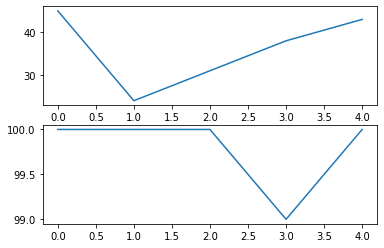

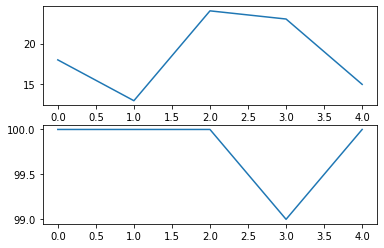

In [122]:
analisis()